In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

In [5]:
df.head()

,Date,Close_gold
0,2000/08/30,273.899994
1,2000/08/31,278.299988
2,2000/09/01,277.000000
3,2000/09/05,275.799988
4,2000/09/06,274.200012


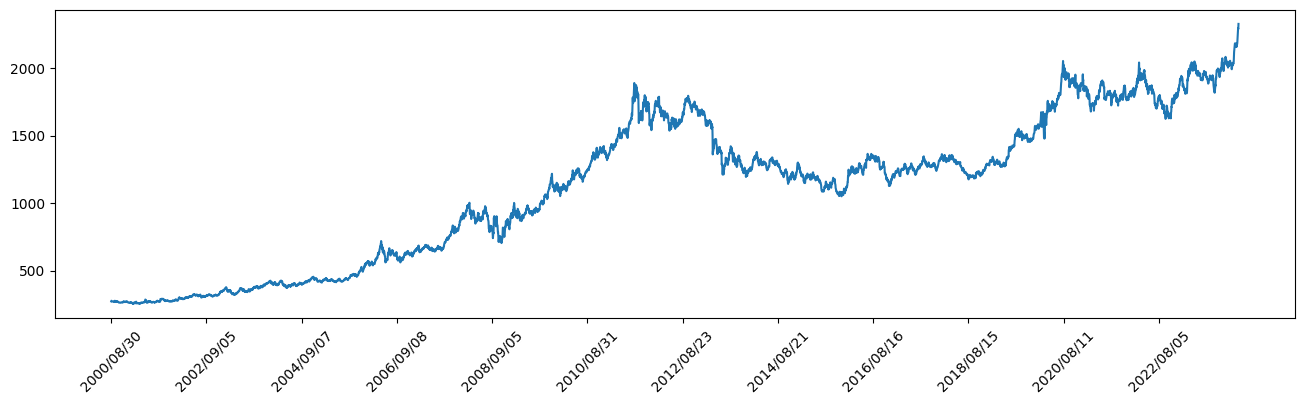

In [6]:
plt.figure(figsize=(16, 4))
plt.plot(df['Close_gold'])
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.show();

Feature building

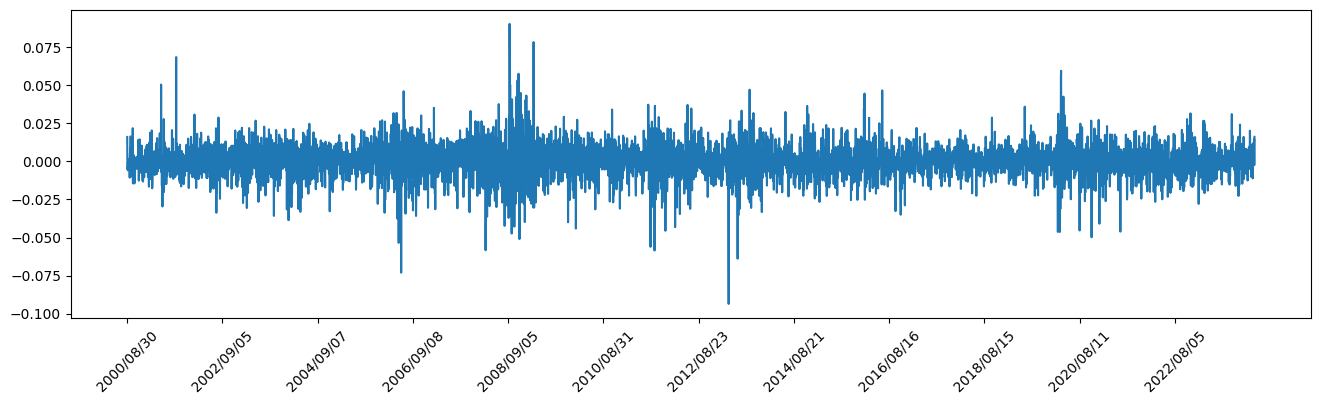

In [7]:
#calculate the percentage change
df['returns'] = df['Close_gold'].pct_change()

plt.figure(figsize=(16, 4))
plt.plot(df['returns'])
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.show();

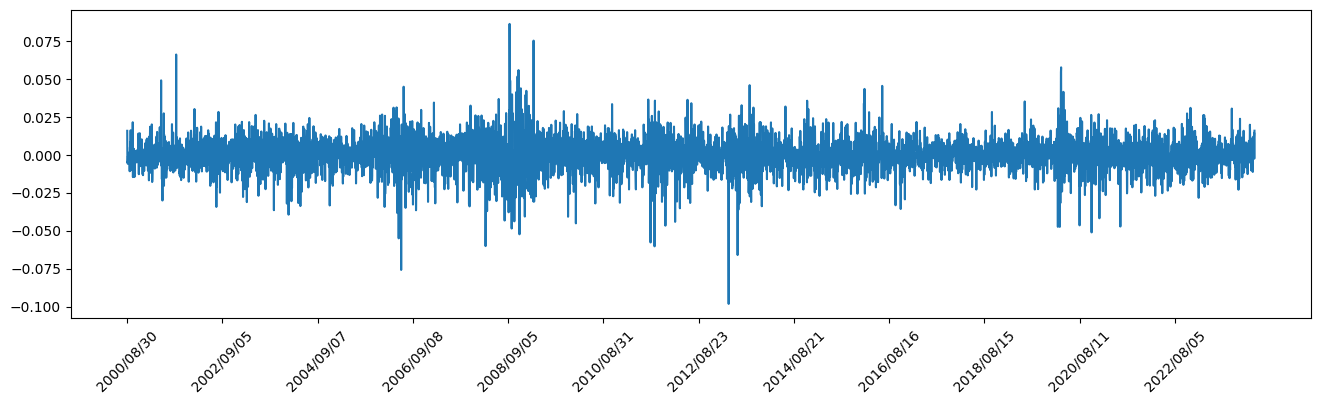

In [8]:
#calculate the log returns
#https://quantivity.wordpress.com/2011/02/21/why-log-returns/
df['log_returns'] = np.log(1 + df['returns'])

plt.figure(1, figsize=(16,4))
plt.plot(df['log_returns'])
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.show();

In [9]:
print(df.shape)
#drop rows with missing values
df = df.dropna(how='any')
print(df.shape)

(5919, 4)
(5918, 4)


In [10]:
#create feature matrix X
X = df[['Close_gold', 'log_returns']].values

In [11]:
#data normalization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

#create target vector y
y = [x[0] for x in X_scaled]

In [12]:
#data split into train, test and validation sets
split_1 = int(len(X_scaled) * 0.8)
split_2 = int(len(X_scaled) * 0.95)

X_train = X_scaled[:split_1]
X_validation = X_scaled[split_1 : split_2]
X_test = X_scaled[split_2 : len(X_scaled)]
y_train = y[:split_1]
y_validation = y[split_1 : split_2]
y_test = y[split_2 : len(y)]

In [13]:
#test the lengths
assert len(X_train) == len(y_train)
assert len(X_validation) == len(y_validation)
assert len(X_test) == len(y_test)

In [14]:
#labeling
n = 3
Xtrain = []
ytrain = []
Xvalidation = []
yvalidation = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n: i, : X_train.shape[1]])
    ytrain.append(y_train[i])
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n: i, : X_test.shape[1]])
    ytest.append(y_test[i])
for i in range(n,len(X_validation)):
    Xvalidation.append(X_validation[i - n: i, : X_validation.shape[1]])
    yvalidation.append(y_validation[i])

In [15]:
#revers transformation example
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape)]
result = scaler.inverse_transform(val)
result

array([[ 2.74200012e+02, -9.82057917e-02]])

In [16]:
#LSTM inputs reshaping
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xvalidation, yvalidation = (np.array(Xvalidation), np.array(yvalidation))
Xvalidation = np.reshape(Xvalidation, (Xvalidation.shape[0], Xvalidation.shape[1], Xvalidation.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

print(Xtrain.shape)
print(ytrain.shape)
print(Xvalidation.shape)
print(yvalidation.shape)
print(Xtest.shape)
print(ytest.shape)

(4731, 3, 2)
(4731,)
(885, 3, 2)
(885,)
(293, 3, 2)
(293,)


Model

In [52]:
import tensorflow as tf
import keras
from keras import layers, models, metrics, activations
from keras.metrics import mean_squared_error, mean_absolute_error
from keras.activations import tanh, relu, sigmoid
from keras.layers import Dense, LSTM, Dropout, Input
from keras.models import Sequential, save_model
from keras.optimizers import Adam

from keras.callbacks import History, EarlyStopping

In [59]:
def build_3l_model(lstm_nodes_1 = 20, lstm_nodes_2 = 30, lstm_nodes_3 = 30, dense_nodes_1 = 20,
                   input_shape = (Xtrain.shape[1], Xtrain.shape[2]),
                   dropout = 0.05, activation_lstm = 'tanh', activation_dense = 'tanh', loss = 'mean_squared_error', learning_rate = 0.00005):
    model = Sequential([
        Input(shape = input_shape),
        LSTM(lstm_nodes_1, dropout = dropout, activation = activation_lstm, return_sequences = True),
        LSTM(lstm_nodes_2, dropout = dropout, activation = activation_lstm, return_sequences = True),
        LSTM(lstm_nodes_3, dropout = dropout, activation = activation_lstm),
        Dense(dense_nodes_1, activation = activation_dense),
        Dense(1)
        ])
    
    model.compile(loss = loss,
                  optimizer = Adam(learning_rate = learning_rate),
                  metrics = [mean_squared_error, mean_absolute_error])
    return model

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

$n$ is the number of samples in the dataset

$y_i$ is the actual target value for the ith sample

$\hat{y}_i$ is the predicted value for the ith sample


$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

$n$ is the number of samples in the dataset

$y_i$ is the actual target value for the ith sample

$\hat{y}_i$ is the predicted value for the ith sample

In [19]:
iterations_summary = pd.DataFrame(columns = ['iteration', 'loss', 'val_loss', 'mean_squared_error','val_mean_squared_error',
                                             'mean_absolute_error', 'val_mean_absolute_error', 'stopped_epoch', 'best_performer'])

In [20]:
#Monte Carlo dropout training set up
batch_size = 64
epochs = 5_000
patience = 500
start_from_epoch = 1_500
#validation data set
validation_data = (Xvalidation, yvalidation)

In [71]:
#Monte Carlo dropout training
from datetime import datetime
import  json
import os

iterations_summary = iterations_summary[0:0]
time_stamp = datetime.now().strftime('%Y-%m-%d')

early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, verbose = 1, restore_best_weights = True,
                               start_from_epoch = start_from_epoch)

model = build_3l_model(lstm_nodes_1 = 20, lstm_nodes_2 = 30, lstm_nodes_3 = 30, dense_nodes_1 = 20,
                       input_shape = (Xtrain.shape[1], Xtrain.shape[2]), dropout = 0.05, activation_lstm = 'tanh',
                       activation_dense = 'tanh', loss = 'mean_squared_error', learning_rate = 0.00005)

iterations_summary = pd.DataFrame(columns = ['iteration', 'loss', 'val_loss', 'mean_squared_error','val_mean_squared_error',
                                             'mean_absolute_error', 'val_mean_absolute_error', 'stopped_epoch'])

def monte_carlo_dropout(model = model, Xtrain = Xtrain, ytrain = ytrain, validation_data = validation_data,
                        epochs = epochs, batch_size = batch_size, early_stopping = early_stopping,
                        n = 100):
    for iteration in range(n):
        fitt_model = model.fit(Xtrain, ytrain, batch_size = batch_size, epochs = epochs, validation_data = validation_data,
                               verbose = 0, callbacks = [early_stopping])
        
        stopped_epoch = early_stopping.stopped_epoch
        
        #save model
        models_folder_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/{0}-monte-carlo/{0}-models'.format(time_stamp)
        os.makedirs(models_folder_path, exist_ok = True)
        model_files_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/{0}-monte-carlo/{0}-models/{0}_lstm_model_monte_carlo_{1}.keras'.format(time_stamp, iteration)
        model.save(model_files_path)
                         
        #save model history
        model_history = fitt_model.history
        history_folder_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/{0}-monte-carlo/{0}-history'.format(time_stamp)
        os.makedirs(history_folder_path, exist_ok = True)
                                
        history_files_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/{0}-monte-carlo/{0}-history/{0}_lstm_model_history_{1}.json'.format(time_stamp, iteration)
        with open(history_files_path, 'w') as json_file:
            json.dump(model_history, json_file)
                                                                
        iteration_row = {'iteration': iteration,
                      'loss': fitt_model.history['loss'][-1],
                      'val_loss': fitt_model.history['val_loss'][-1],
                      'mean_squared_error': fitt_model.history['mean_squared_error'][-1],
                      'val_mean_squared_error': fitt_model.history['val_mean_squared_error'][-1],
                      'mean_absolute_error': fitt_model.history['mean_absolute_error'][-1],
                      'val_mean_absolute_error': fitt_model.history['val_mean_absolute_error'][-1],
                      'stopped_epoch': stopped_epoch}
                                   
        iterations_summary.loc[iteration] = iteration_row
    
    #save training summary to csv
    return iterations_summary.to_csv('/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/{0}-monte-carlo/{0}_lstm_iterations_summary.csv'.format(time_stamp), index = False)

In [72]:
monte_carlo_dropout(model = model, Xtrain = Xtrain, ytrain = ytrain, validation_data = validation_data,
                        epochs = epochs, batch_size = batch_size, early_stopping = early_stopping,
                        n = 100)